In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [32]:
df = pd.read_csv('S&P500.csv', sep=";", index_col="Date")
df = df[df.columns[1:27]]
df = df.replace('N', np.NaN)
df = df.dropna()

In [37]:
scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(len(df.columns))]
for i in range(len(df.columns)):
    df[df.columns[i]] = scalers[i].fit_transform(df[df.columns[i]].values.reshape(-1,1))
data_raw = df.values
for i in range(4):
    data_raw[:, i] = np.concatenate((np.diff(data_raw[:, i]), np.zeros(1)))



(1571, 26)


In [47]:
data = []
window_size = 70
train_ratio = 0.8


for i in range(len(data_raw) - window_size):
    data.append(data_raw[i : i + window_size])

data = np.array(data)
print(data.shape)
data = data.reshape((data.shape[0], data.shape[1], -1))
train_size = int(train_ratio * data.shape[0])
x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor)
y_train = torch.from_numpy(data[:train_size, -1, 1]).type(torch.Tensor).reshape(-1, 1)

x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor)
y_test = torch.from_numpy(data[train_size:, -1, 1]).type(torch.Tensor).reshape(-1, 1)

(1501, 70, 26)


In [61]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


model = LSTM(input_dim=26, hidden_dim=40, num_layers=4, output_dim=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [62]:
numEpochs = 80
history = np.zeros(numEpochs)
test_loss = []
for t in range(numEpochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    history[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t != 0:
        print("Epoch", t)
        print("Train MSE:", history[t])
        y_test_pred = model(x_test)
        loss = loss_fn(y_test_pred, y_test)
        test_loss.append(loss.item())
        print("Test MSE:", loss.item())
        print()
    




Epoch 10
Train MSE: 0.0009169317199848592
Test MSE: 0.0013651051558554173

Epoch 20
Train MSE: 0.000653858354780823
Test MSE: 0.0013079242780804634

Epoch 30
Train MSE: 0.0006009532371535897
Test MSE: 0.001262519508600235

Epoch 40
Train MSE: 0.000592805678024888
Test MSE: 0.0012610150733962655

Epoch 50
Train MSE: 0.0005921602132730186
Test MSE: 0.0012765544233843684

Epoch 60
Train MSE: 0.0005876838113181293
Test MSE: 0.0012699355138465762



KeyboardInterrupt: 

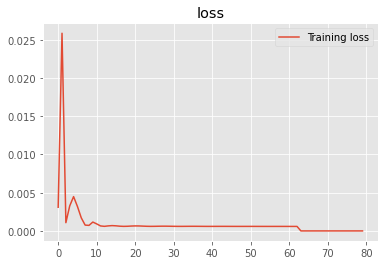

In [65]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(history, label="Training loss")
plt.legend()
plt.title('loss')
plt.show()

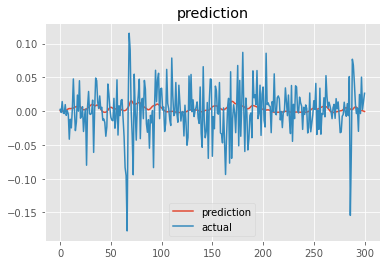

In [67]:
y_test_pred_graph = scalers[1].inverse_transform(y_test_pred.detach().numpy())
y_test_graph = scalers[1].inverse_transform(y_test.detach().numpy())
binary_pred = y_test_pred_graph > 0
binary_actual = y_test_graph > 0
plt.plot(y_test_pred_graph, label='prediction')
plt.plot(y_test_graph, label='actual')
plt.title("prediction")
plt.legend()
plt.show()